In [2]:
# 📦 Essential Libraries
import pandas as pd
import numpy as np
import copy

# 📊 Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # Optional: set default Seaborn theme
%matplotlib inline  

# 📈 Statistics and Modeling
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 🧠 Machine Learning
from sklearn.model_selection import train_test_split, GroupShuffleSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# 🗃️ Other
import kagglehub

# 🛠️ Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


In [3]:
#Step 1. Load the data
train = pd.read_csv(r"C:\Users\chris\OneDrive\Documents\Data Science\Machine Learning\UnSup. ML C2\bbc_train.csv");
test = pd.read_csv(r"C:\Users\chris\OneDrive\Documents\Data Science\Machine Learning\UnSup. ML C2\BBC_test.csv");

# Step 2. Exploratory data analysis

# Print the first rows
print("\n--- Head ---\n",train.head())
print() 

# Print general information about the dataframe
print("\n--- Info ---\n", train.info())
print()

# Print statistics from numerical variables
print("\n--- Describe ---\n", train.describe())
print()

# Verify if there are null values
print("\n--- Null ---\n",train.isnull().sum())
print()

# Find out how many are in each category
print("\n--- Counts ---\n", train['Category'].value_counts())



--- Head ---
    ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB

--- Info ---
 None


--- Describe ---
          ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750

In [4]:
train['Length'] = train['Text'].apply(lambda x: len(str(x).split()))
print(train['Length'].describe())


count    1490.000000
mean      385.012752
std       210.898616
min        90.000000
25%       253.000000
50%       337.000000
75%       468.750000
max      3345.000000
Name: Length, dtype: float64


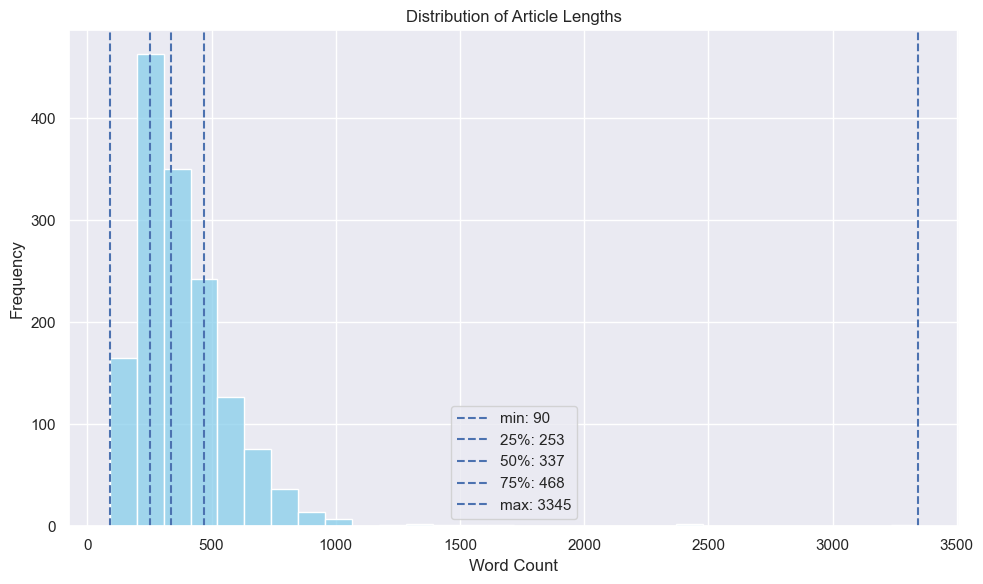

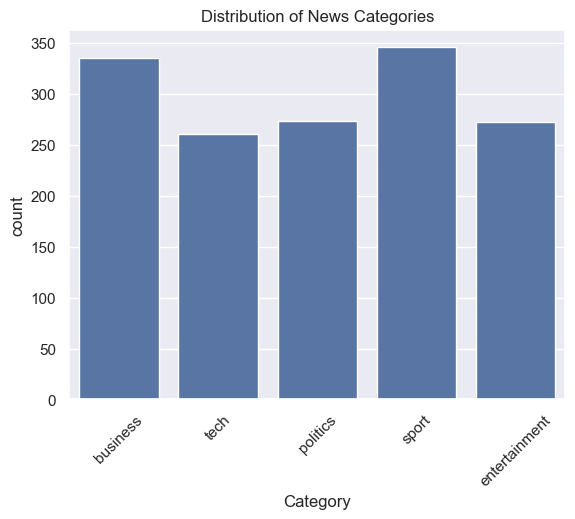

In [5]:
# Compute the stats
stats = train['Length'].describe()

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(train['Length'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Article Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Add vertical lines for summary stats
for label in ['min', '25%', '50%', '75%', 'max']:
    plt.axvline(stats[label], linestyle='--', linewidth=1.5, label=f"{label}: {int(stats[label])}")

# Show legend
plt.legend()
plt.tight_layout()
plt.show()

# Bar chart of categories
sns.countplot(x='Category', data=train)
plt.title('Distribution of News Categories')
plt.xticks(rotation=45)
plt.show()

In [6]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')  # if you're using WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # remove non-word characters
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
train['clean_text'] = train['Text'].apply(clean_text)

In [9]:
train.head()

,ArticleId,Text,Category,Length,clean_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,worldcom ex bos launch defence lawyer defendin...
1,154,german business confidence slides german busin...,business,325,german business confidence slide german busine...
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,bbc poll indicates economic gloom citizen majo...
3,1976,lifestyle governs mobile choice faster bett...,tech,634,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,355,enron boss 168m payout eighteen former enron d...


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(train['clean_text'])

In [22]:
print(X.shape)

(1490, 5000)


In [26]:
# Convert to dense format and put in a DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
#print(tfidf_df.head())

In [20]:
from collections import Counter

all_words = ' '.join(train['clean_text']).split()
word_freq = Counter(all_words)
print(word_freq.most_common(10))

[('said', 4839), ('year', 2172), ('mr', 2007), ('would', 1714), ('also', 1426), ('new', 1338), ('people', 1325), ('one', 1277), ('u', 1273), ('time', 1067)]


In [30]:
import numpy as np

# Get the category labels
categories = train['Category'].unique()

# Convert TF-IDF to a DataFrame for easy manipulation
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df['Category'] = train['Category'].values

# Loop through each category and find top N words
top_words_per_category = {}

for category in categories:
    # Filter rows for the current category
    cat_df = tfidf_df[tfidf_df['Category'] == category].drop('Category', axis=1)
    
    # Compute the average TF-IDF score per word in this category
    mean_tfidf = cat_df.mean(axis=0)
    
    # Get top 10 words
    top_words = mean_tfidf.sort_values(ascending=False).head(10)
    top_words_per_category[category] = top_words

for category, words in top_words_per_category.items():
    print(f"\nTop words for category '{category}':")
    print(words)



Top words for category 'business':
said       0.047091
firm       0.036892
company    0.035696
market     0.033717
growth     0.032747
bank       0.032695
year       0.032170
economy    0.031232
sale       0.030434
share      0.029487
dtype: float64

Top words for category 'tech':
mobile        0.052707
phone         0.046092
people        0.044890
said          0.041919
technology    0.038922
game          0.037576
user          0.037064
service       0.035709
software      0.035345
computer      0.033636
dtype: float64

Top words for category 'politics':
mr            0.087189
labour        0.065814
election      0.065245
said          0.064727
blair         0.056758
party         0.055135
tory          0.047173
government    0.046122
would         0.045583
minister      0.043021
dtype: float64

Top words for category 'sport':
game        0.044889
england     0.037425
win         0.034153
player      0.032379
match       0.031748
said        0.030757
champion    0.029158
cup        

In [36]:
!pip install wordcloud


<Figure size 800x500 with 0 Axes>

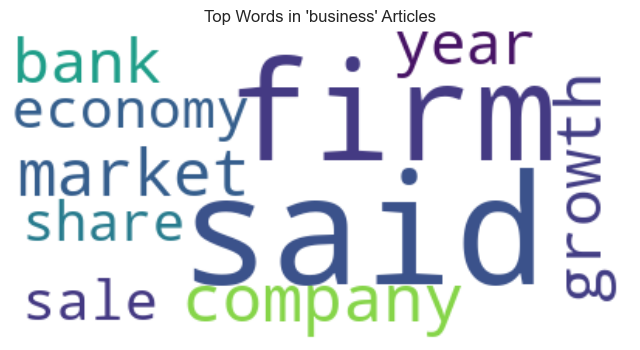

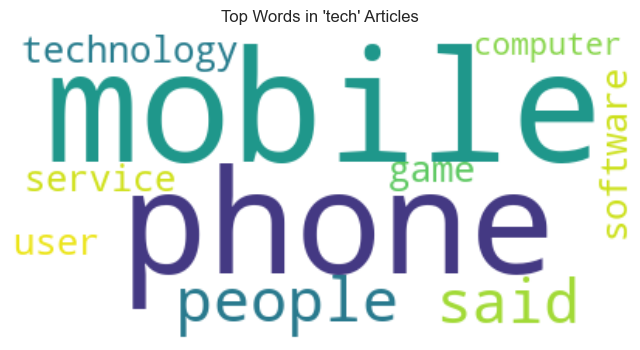

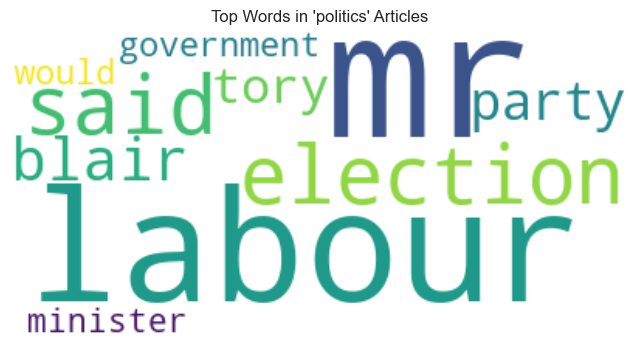

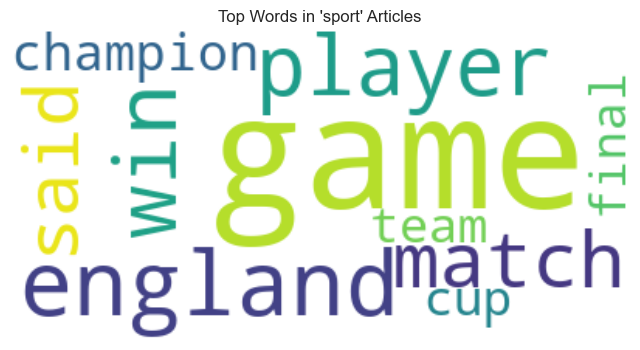

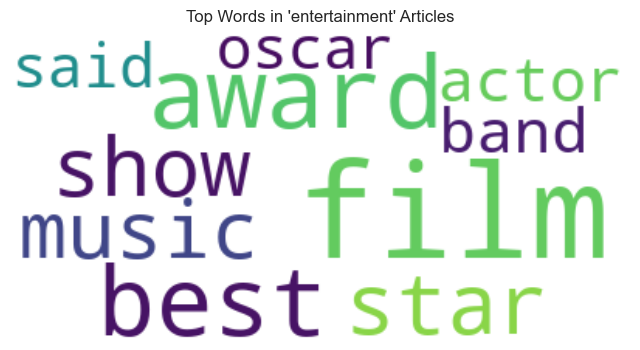

In [38]:
from wordcloud import WordCloud

for category, words in top_words_per_category.items():
    plt.figure(figsize=(8, 5))
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(words.to_dict())
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top Words in '{category}' Articles")
    plt.show()
